In [1]:
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import os
import mytools




# Data Handling

In [2]:
# Make custom dataset
num_sims = int((len(os.listdir('/home/majd/sparse_tensors/'))-1)/3) # -1 because I noticed a .DS_store file was added, /3 
MyDataset = mytools.CustomDataset(dir_loc='/home/majd/sparse_tensors/', N_sims=num_sims)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(MyDataset,[0.6, 0.2, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))
print("Testing samples: ", len(test_dataset))

# Create DataLoaders
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Training samples:  480713
Validation samples:  160238
Testing samples:  160237


In [33]:
# Print tensor shapes
for X_plot, y_plot, idx in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("indices: ", idx.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([128, 1, 120, 120, 120])
Shape of y: torch.Size([128, 3]) torch.float32
indices:  torch.Size([128])


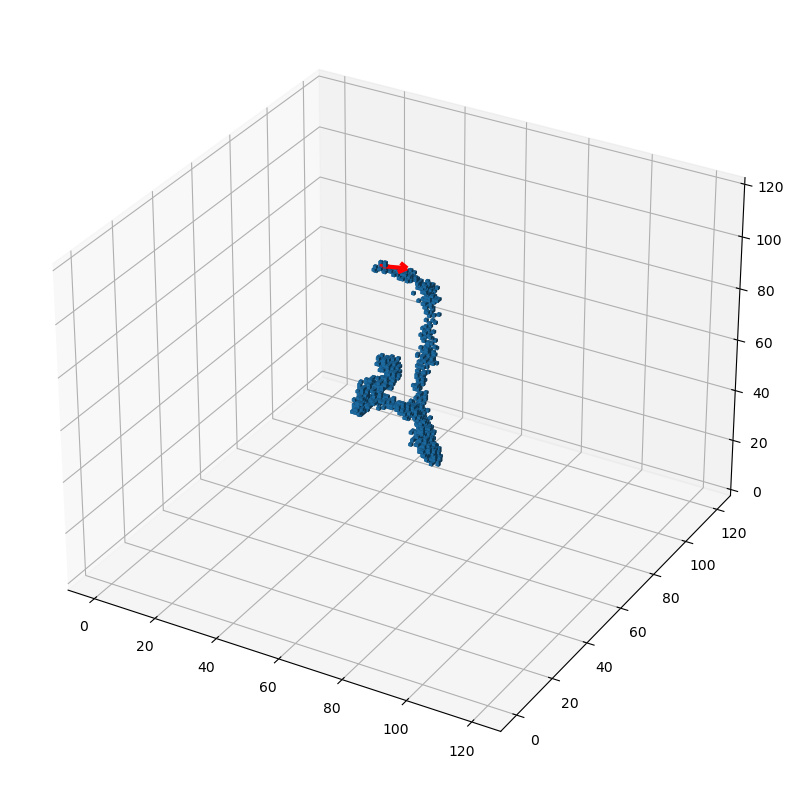

In [35]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = 3.0
# Voxel size in cm
vox_l = 0.05

index = 2
off = torch.load('/home/majd/sparse_tensors/' + 'offset_' + str(idx[index].item()) + '.pt' )
mytools.plot_tensor_dir(tensor = X_plot.to_dense().numpy()[index], start = off, direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)

# Define Convnet Architecture

In [44]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=50, kernel_size=6, stride=2)
        self.pool = nn.MaxPool3d(2, 2, 2)
        self.conv2 = nn.Conv3d(in_channels=50, out_channels=30, kernel_size=4, stride=1, padding='same')
        self.conv3 = nn.Conv3d(in_channels=30, out_channels=20, kernel_size=3, stride=1, padding='same')
        #self.conv4 = nn.Conv2d(100, 80, 6)
        #self.conv5 = nn.Conv2d(80, 40, 6)
        self.fc1 = nn.Linear(67500, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.pool(F.relu(self.conv4(x)))
        #x = F.relu(self.conv5(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

model = NeuralNetwork().to(device)

# Print a nicer model summary
#summary(model, (3, 224, 224))


Using cuda device


In [45]:
print(model)

NeuralNetwork(
  (conv1): Conv3d(1, 50, kernel_size=(6, 6, 6), stride=(2, 2, 2))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv2): Conv3d(50, 30, kernel_size=(4, 4, 4), stride=(1, 1, 1), padding=same)
  (conv3): Conv3d(30, 20, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same)
  (fc1): Linear(in_features=67500, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)
